In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.9.9 pynndescent==0.5.6


In [3]:
results_file = 'write/GSE138922.h5ad'

In [4]:
adata = sc.read_h5ad('VoigtExpressionMatrix.h5ad')
#Single-cell transcriptomics of the human retinal pigment epithelium and choroid in health 
#and macular degeneration

In [5]:
adata

AnnData object with n_obs × n_vars = 6700 × 60609
    obs: 'GSM', 'batch'
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


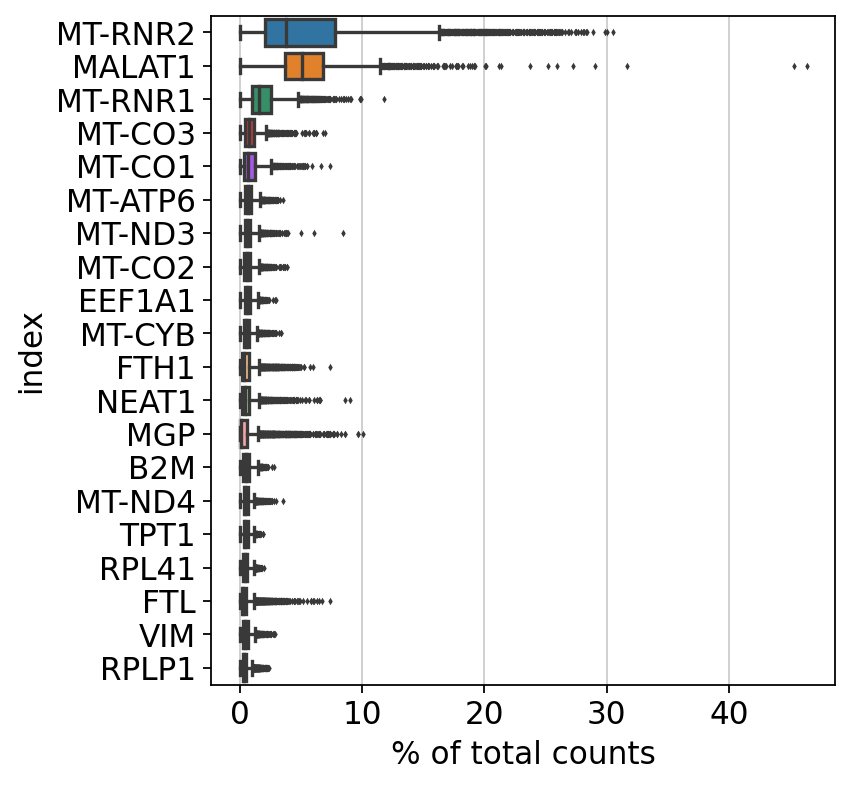

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 28256 genes that are detected in less than 3 cells


In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

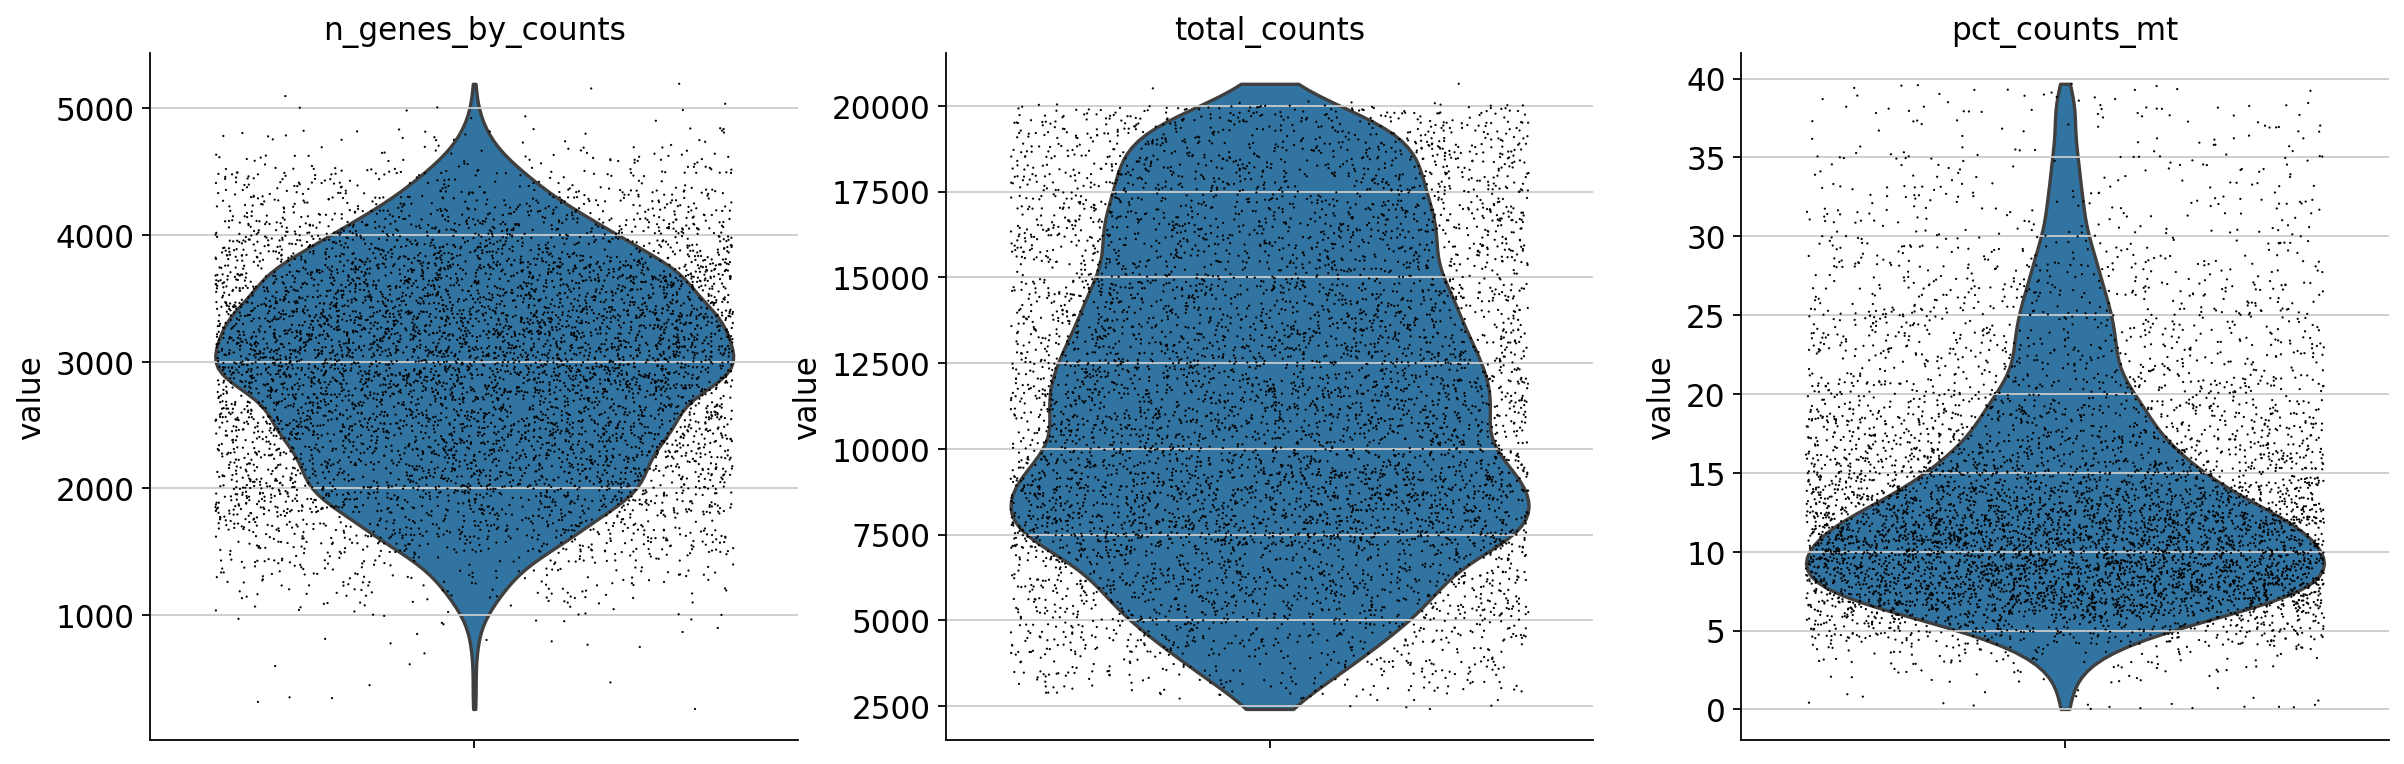

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

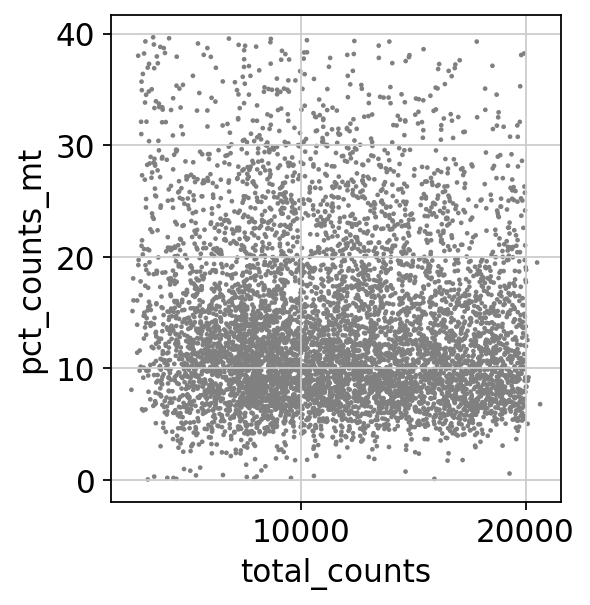

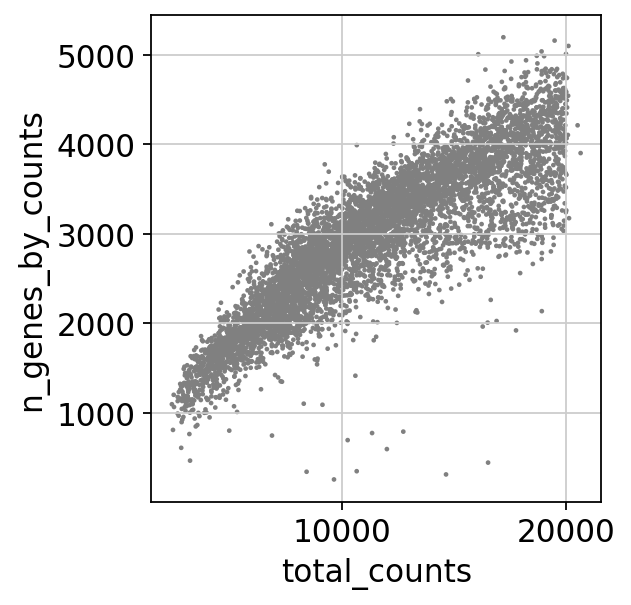

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
adata = adata[adata.obs.n_genes_by_counts > 800, :]
adata = adata[adata.obs.pct_counts_mt < 20, :] #or 25?

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


/home/linux/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


In [13]:
sc.pp.log1p(adata)

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


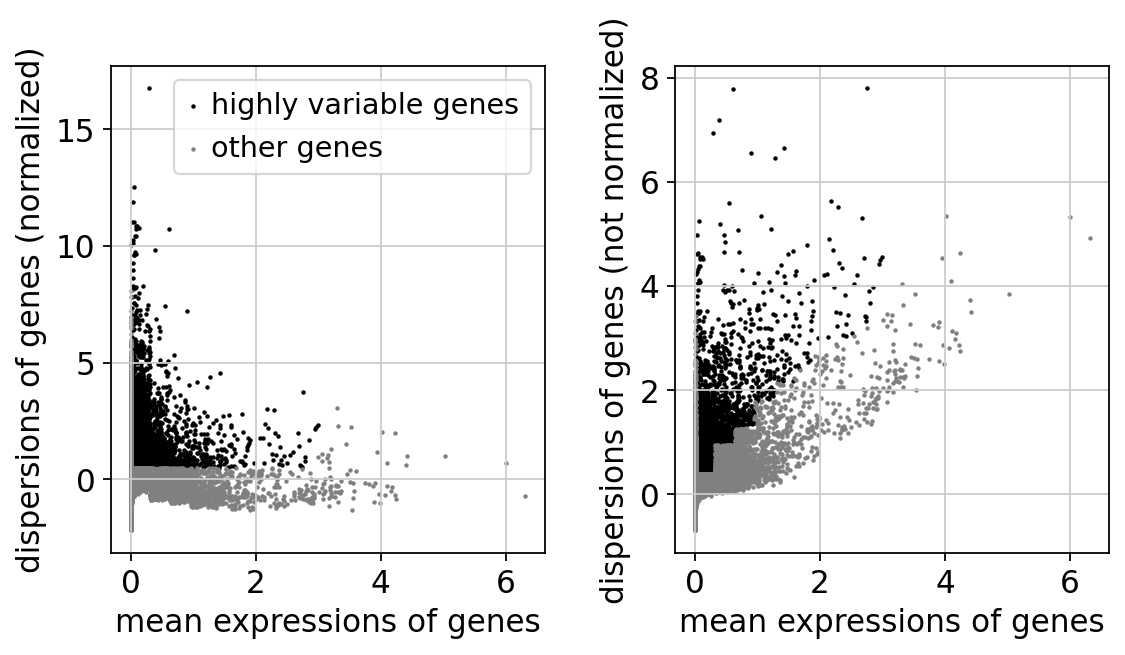

In [15]:
sc.pl.highly_variable_genes(adata)

In [16]:
adata.raw = adata

In [17]:
adata = adata[:, adata.var.highly_variable]

In [18]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:21)


In [19]:
sc.pp.scale(adata, max_value=10)

In [20]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


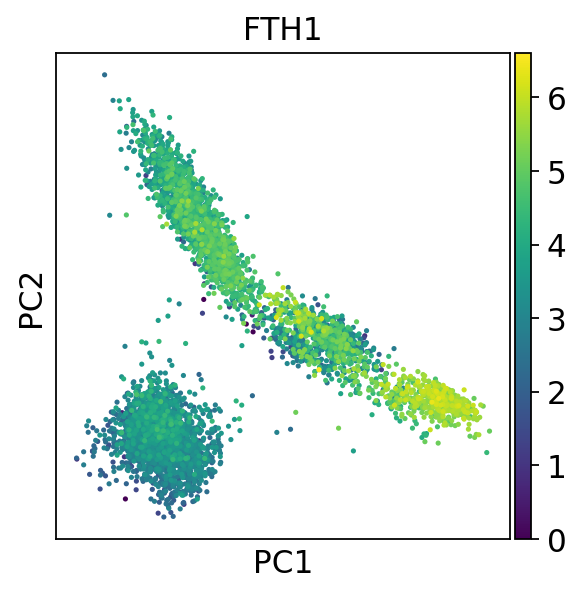

In [21]:
sc.pl.pca(adata, color='FTH1')

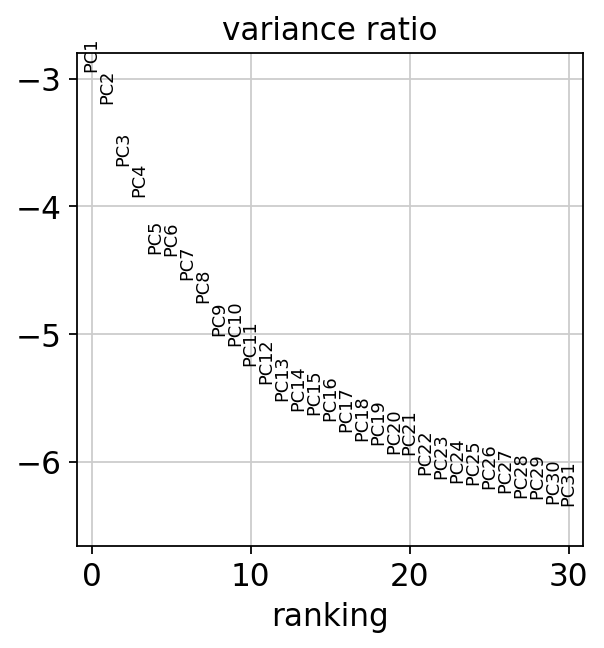

In [22]:
sc.pl.pca_variance_ratio(adata, log=True)

In [23]:
adata.write(results_file)

In [24]:
adata

AnnData object with n_obs × n_vars = 5531 × 3823
    obs: 'GSM', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [25]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


In [26]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


In [27]:
sc.tl.leiden(adata, resolution=0.06)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


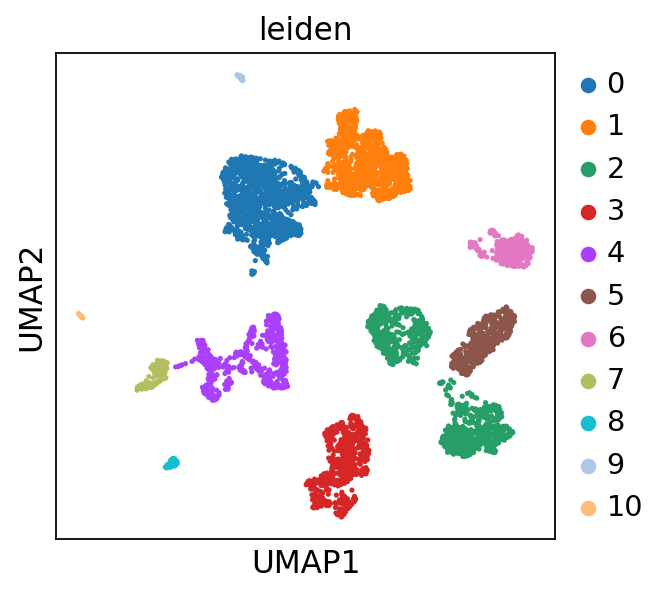

In [28]:
sc.pl.umap(adata, color=['leiden'])

In [29]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


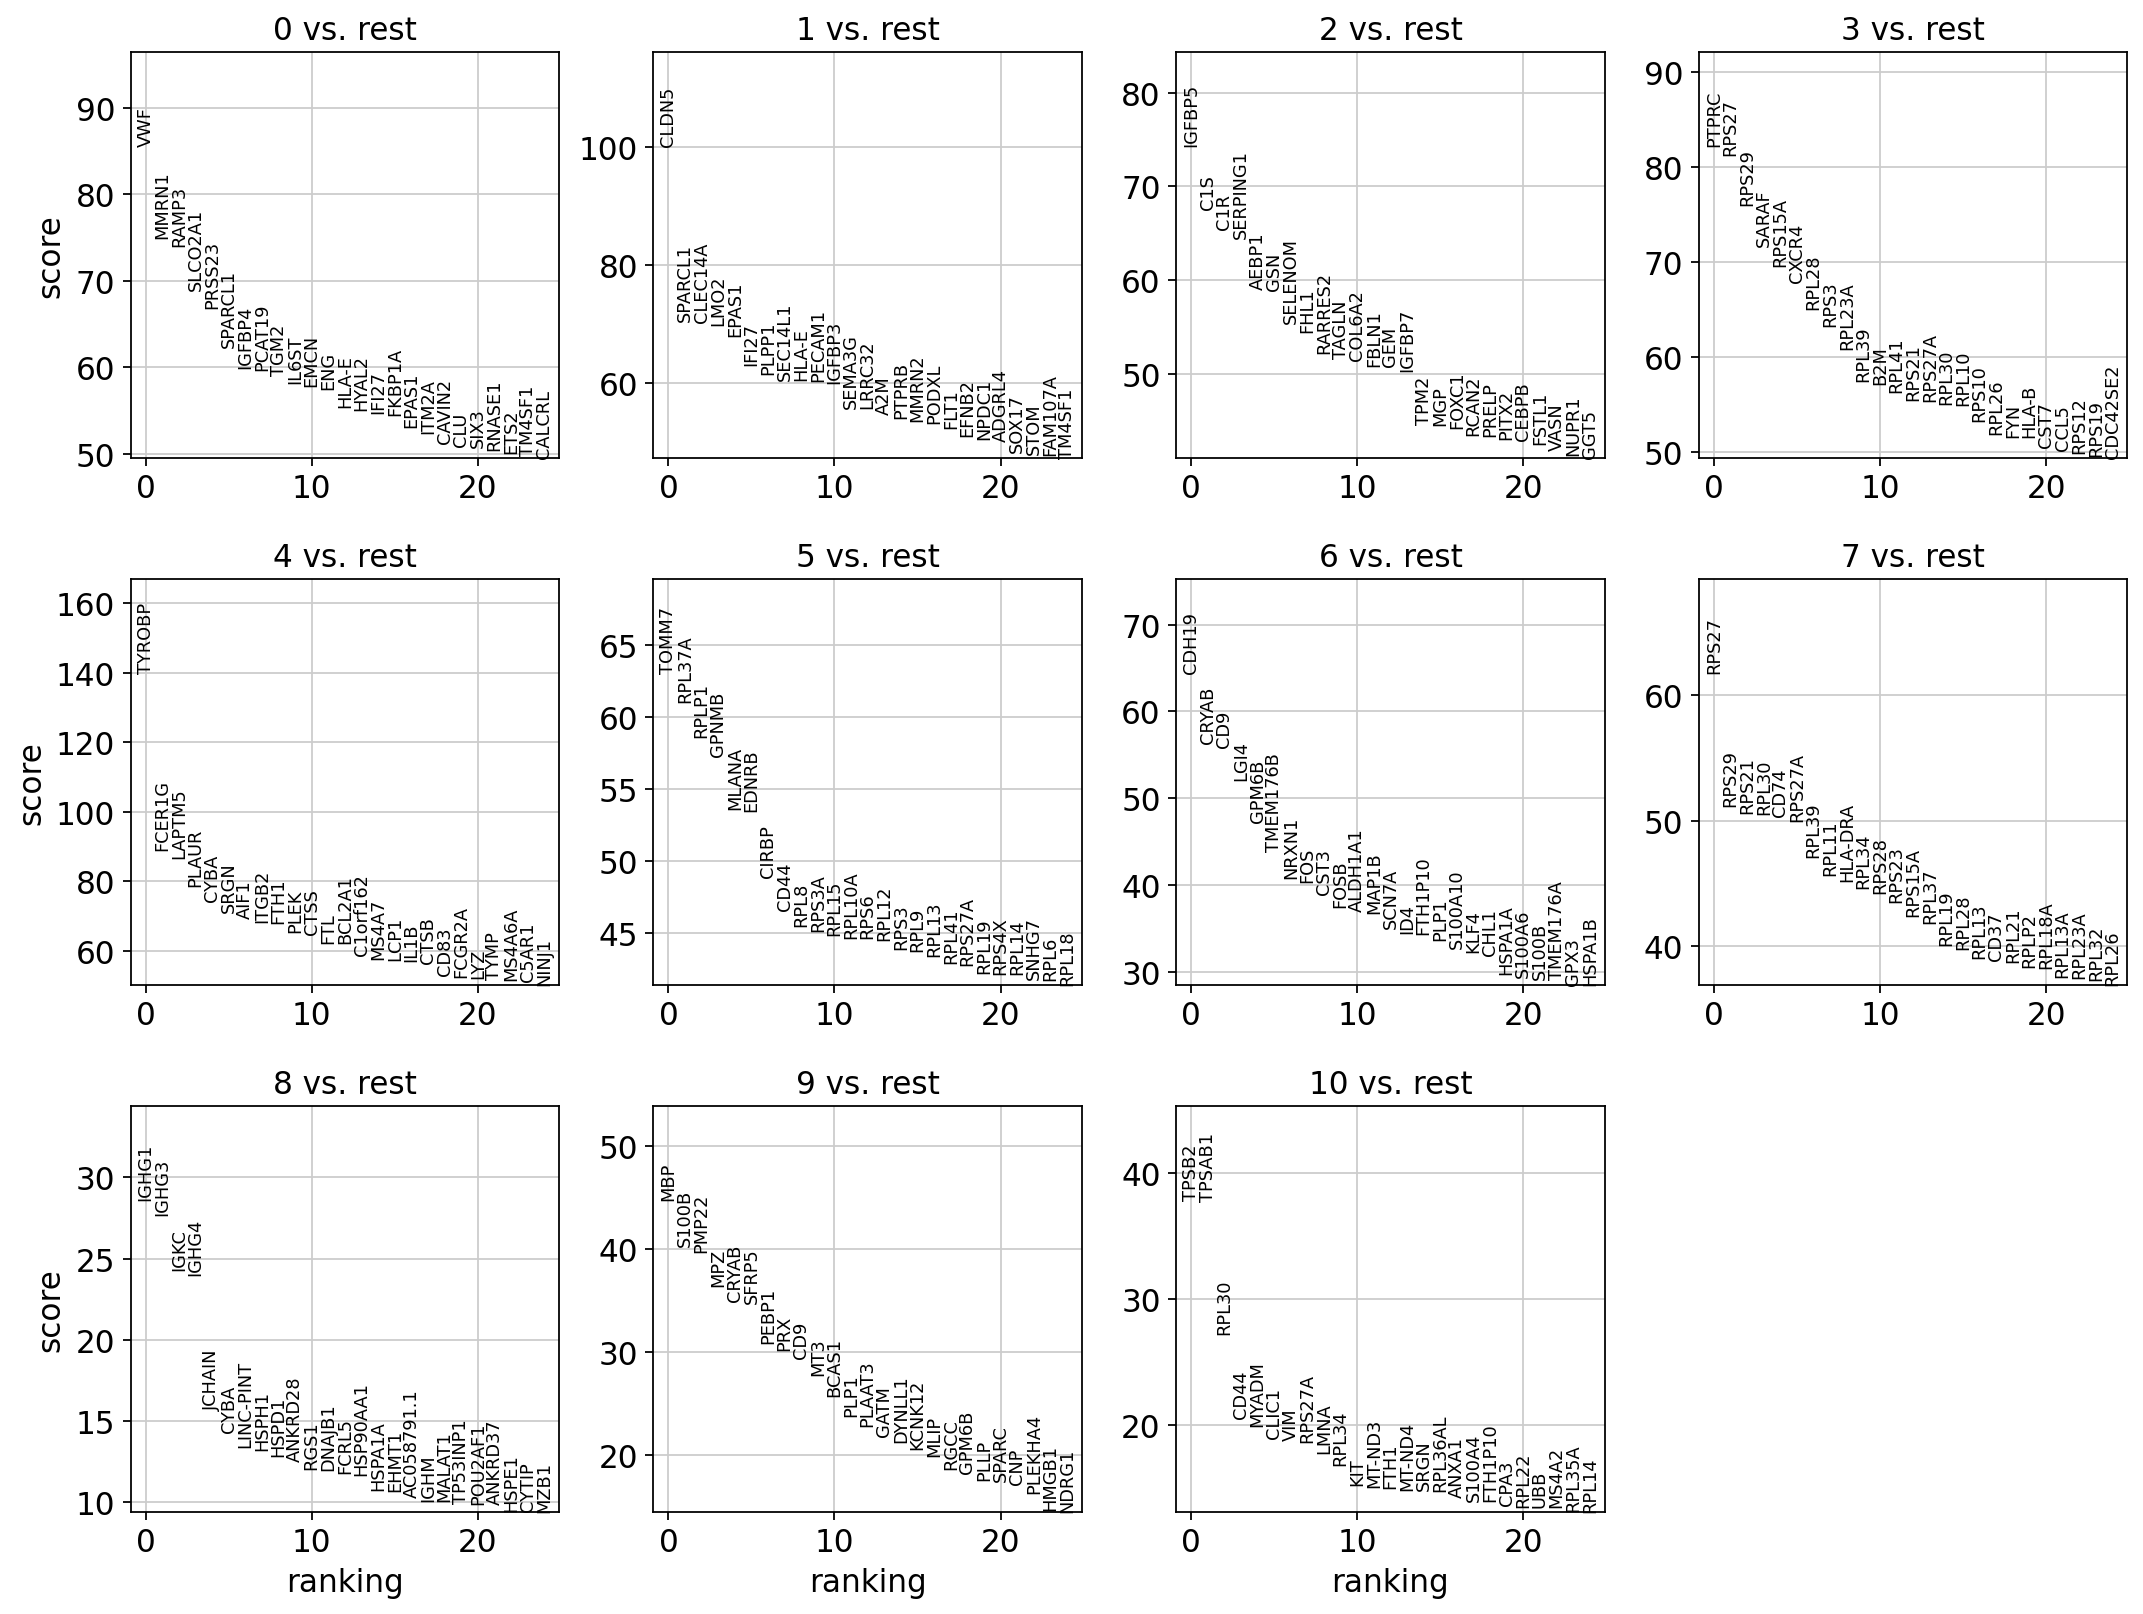

In [30]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [31]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:13)


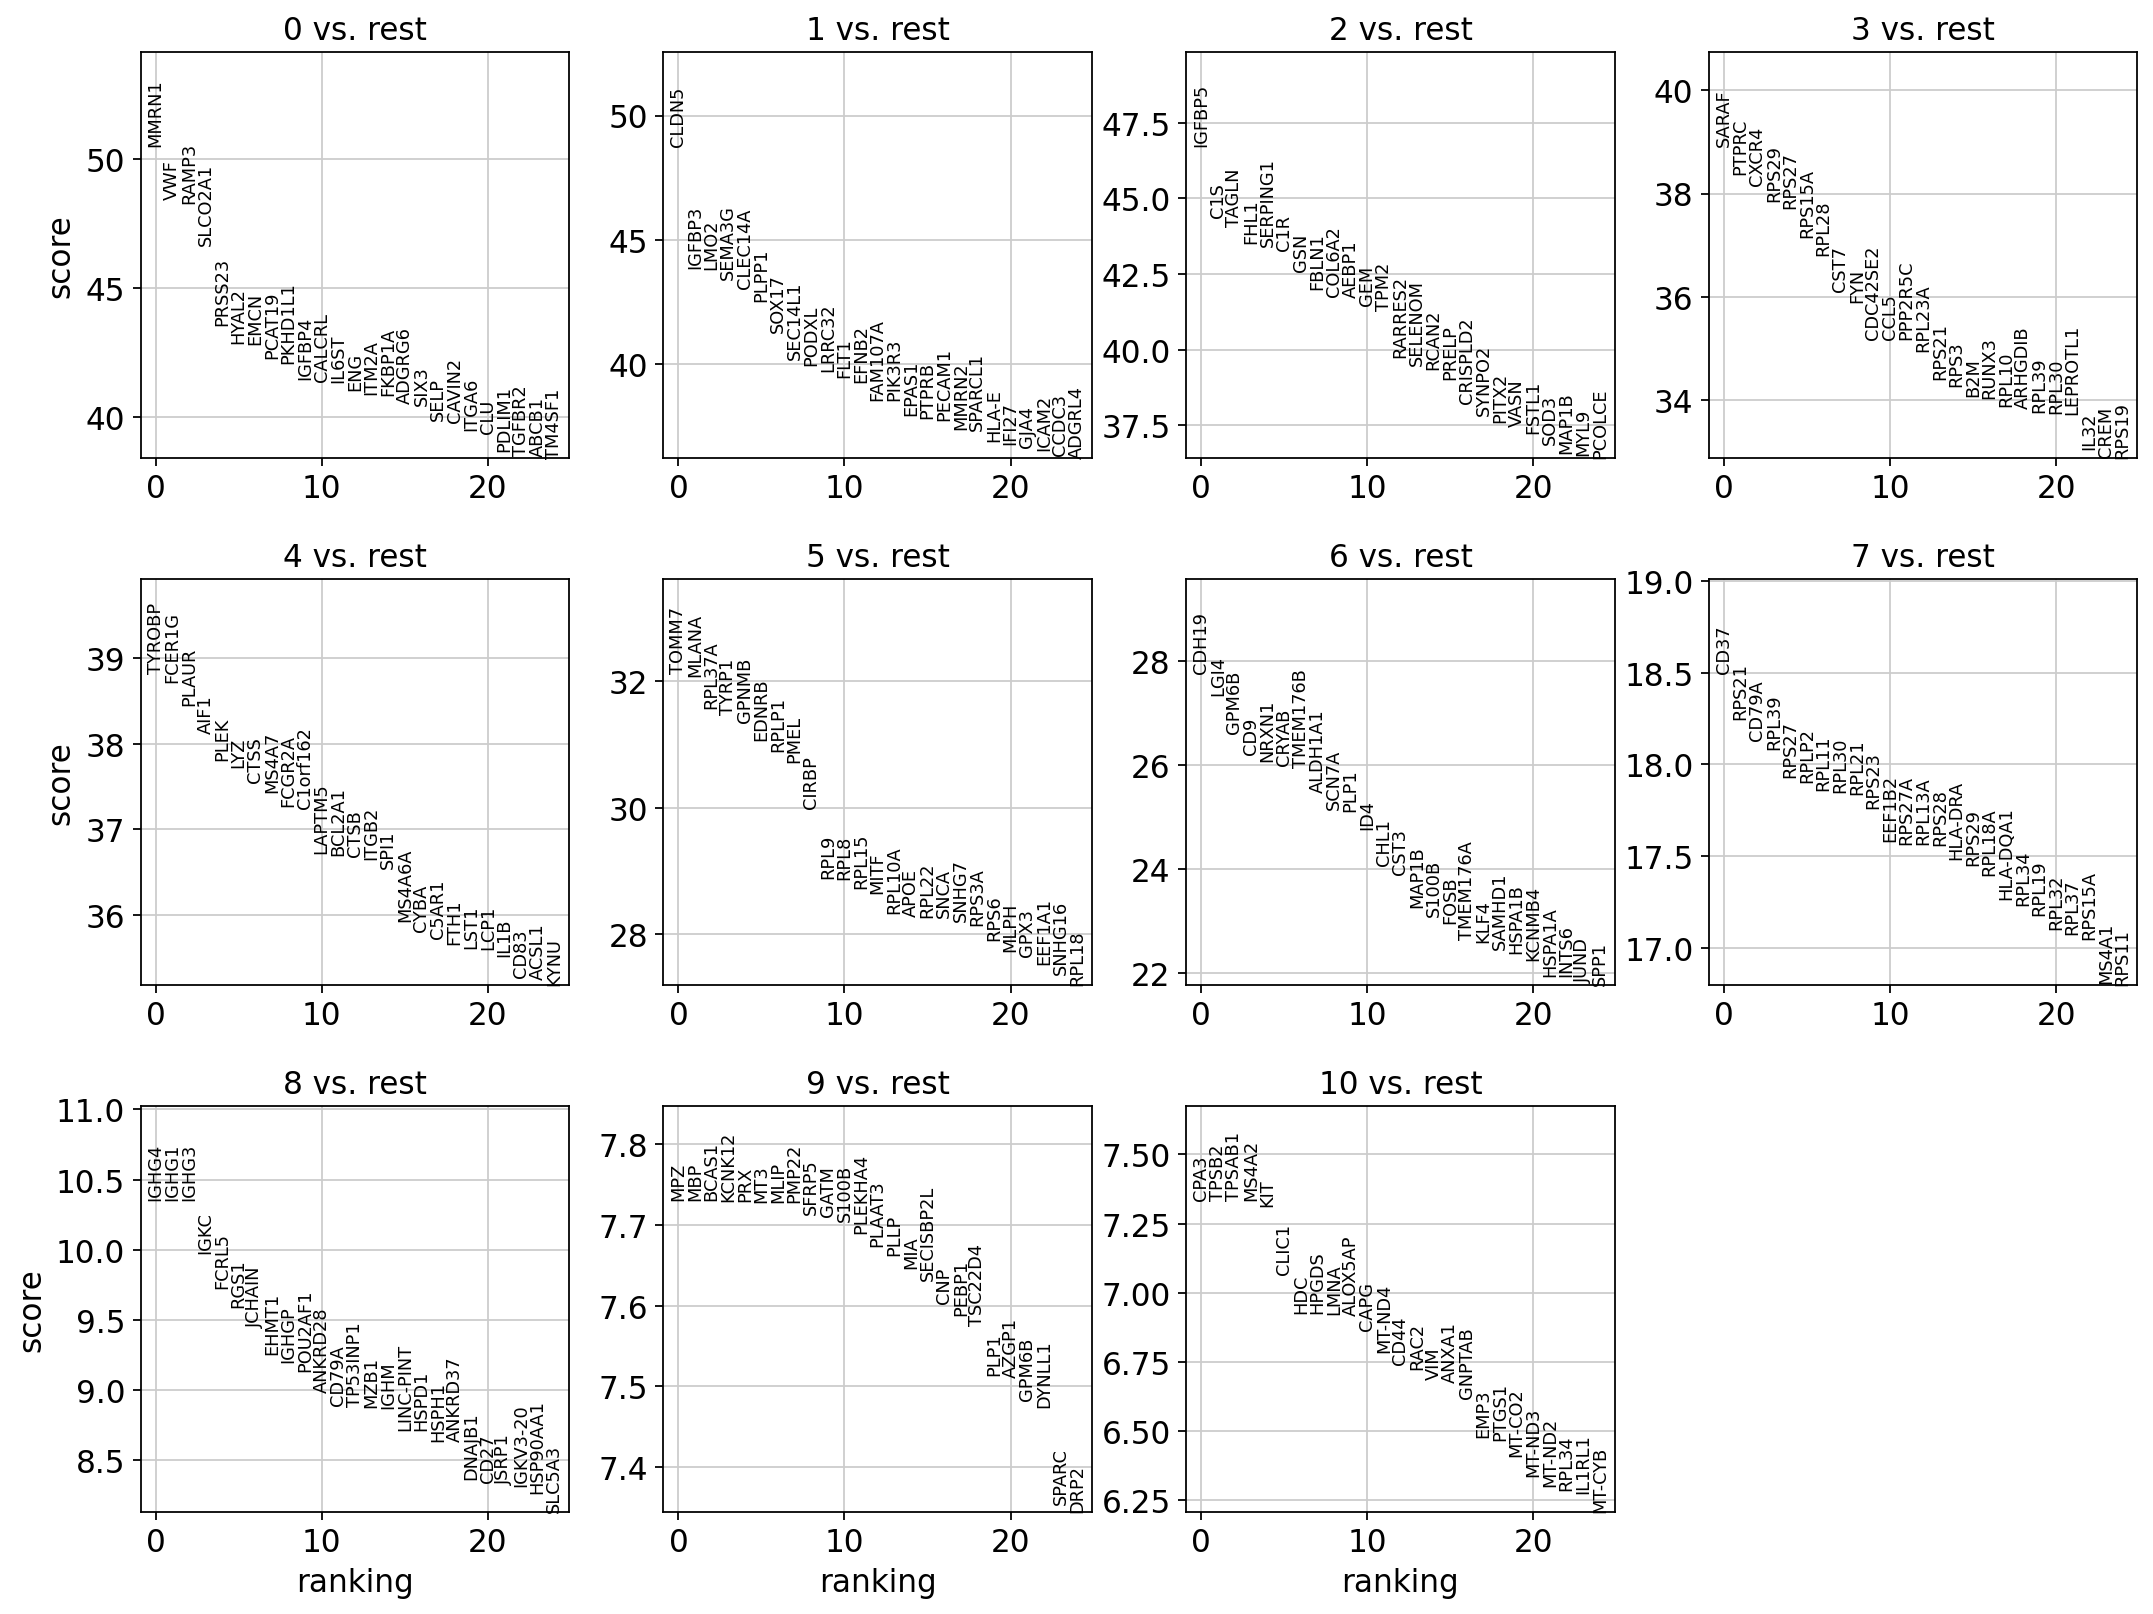

In [32]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [33]:
adata.write(results_file)

ranking genes
    finished (0:00:54)


/home/linux/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


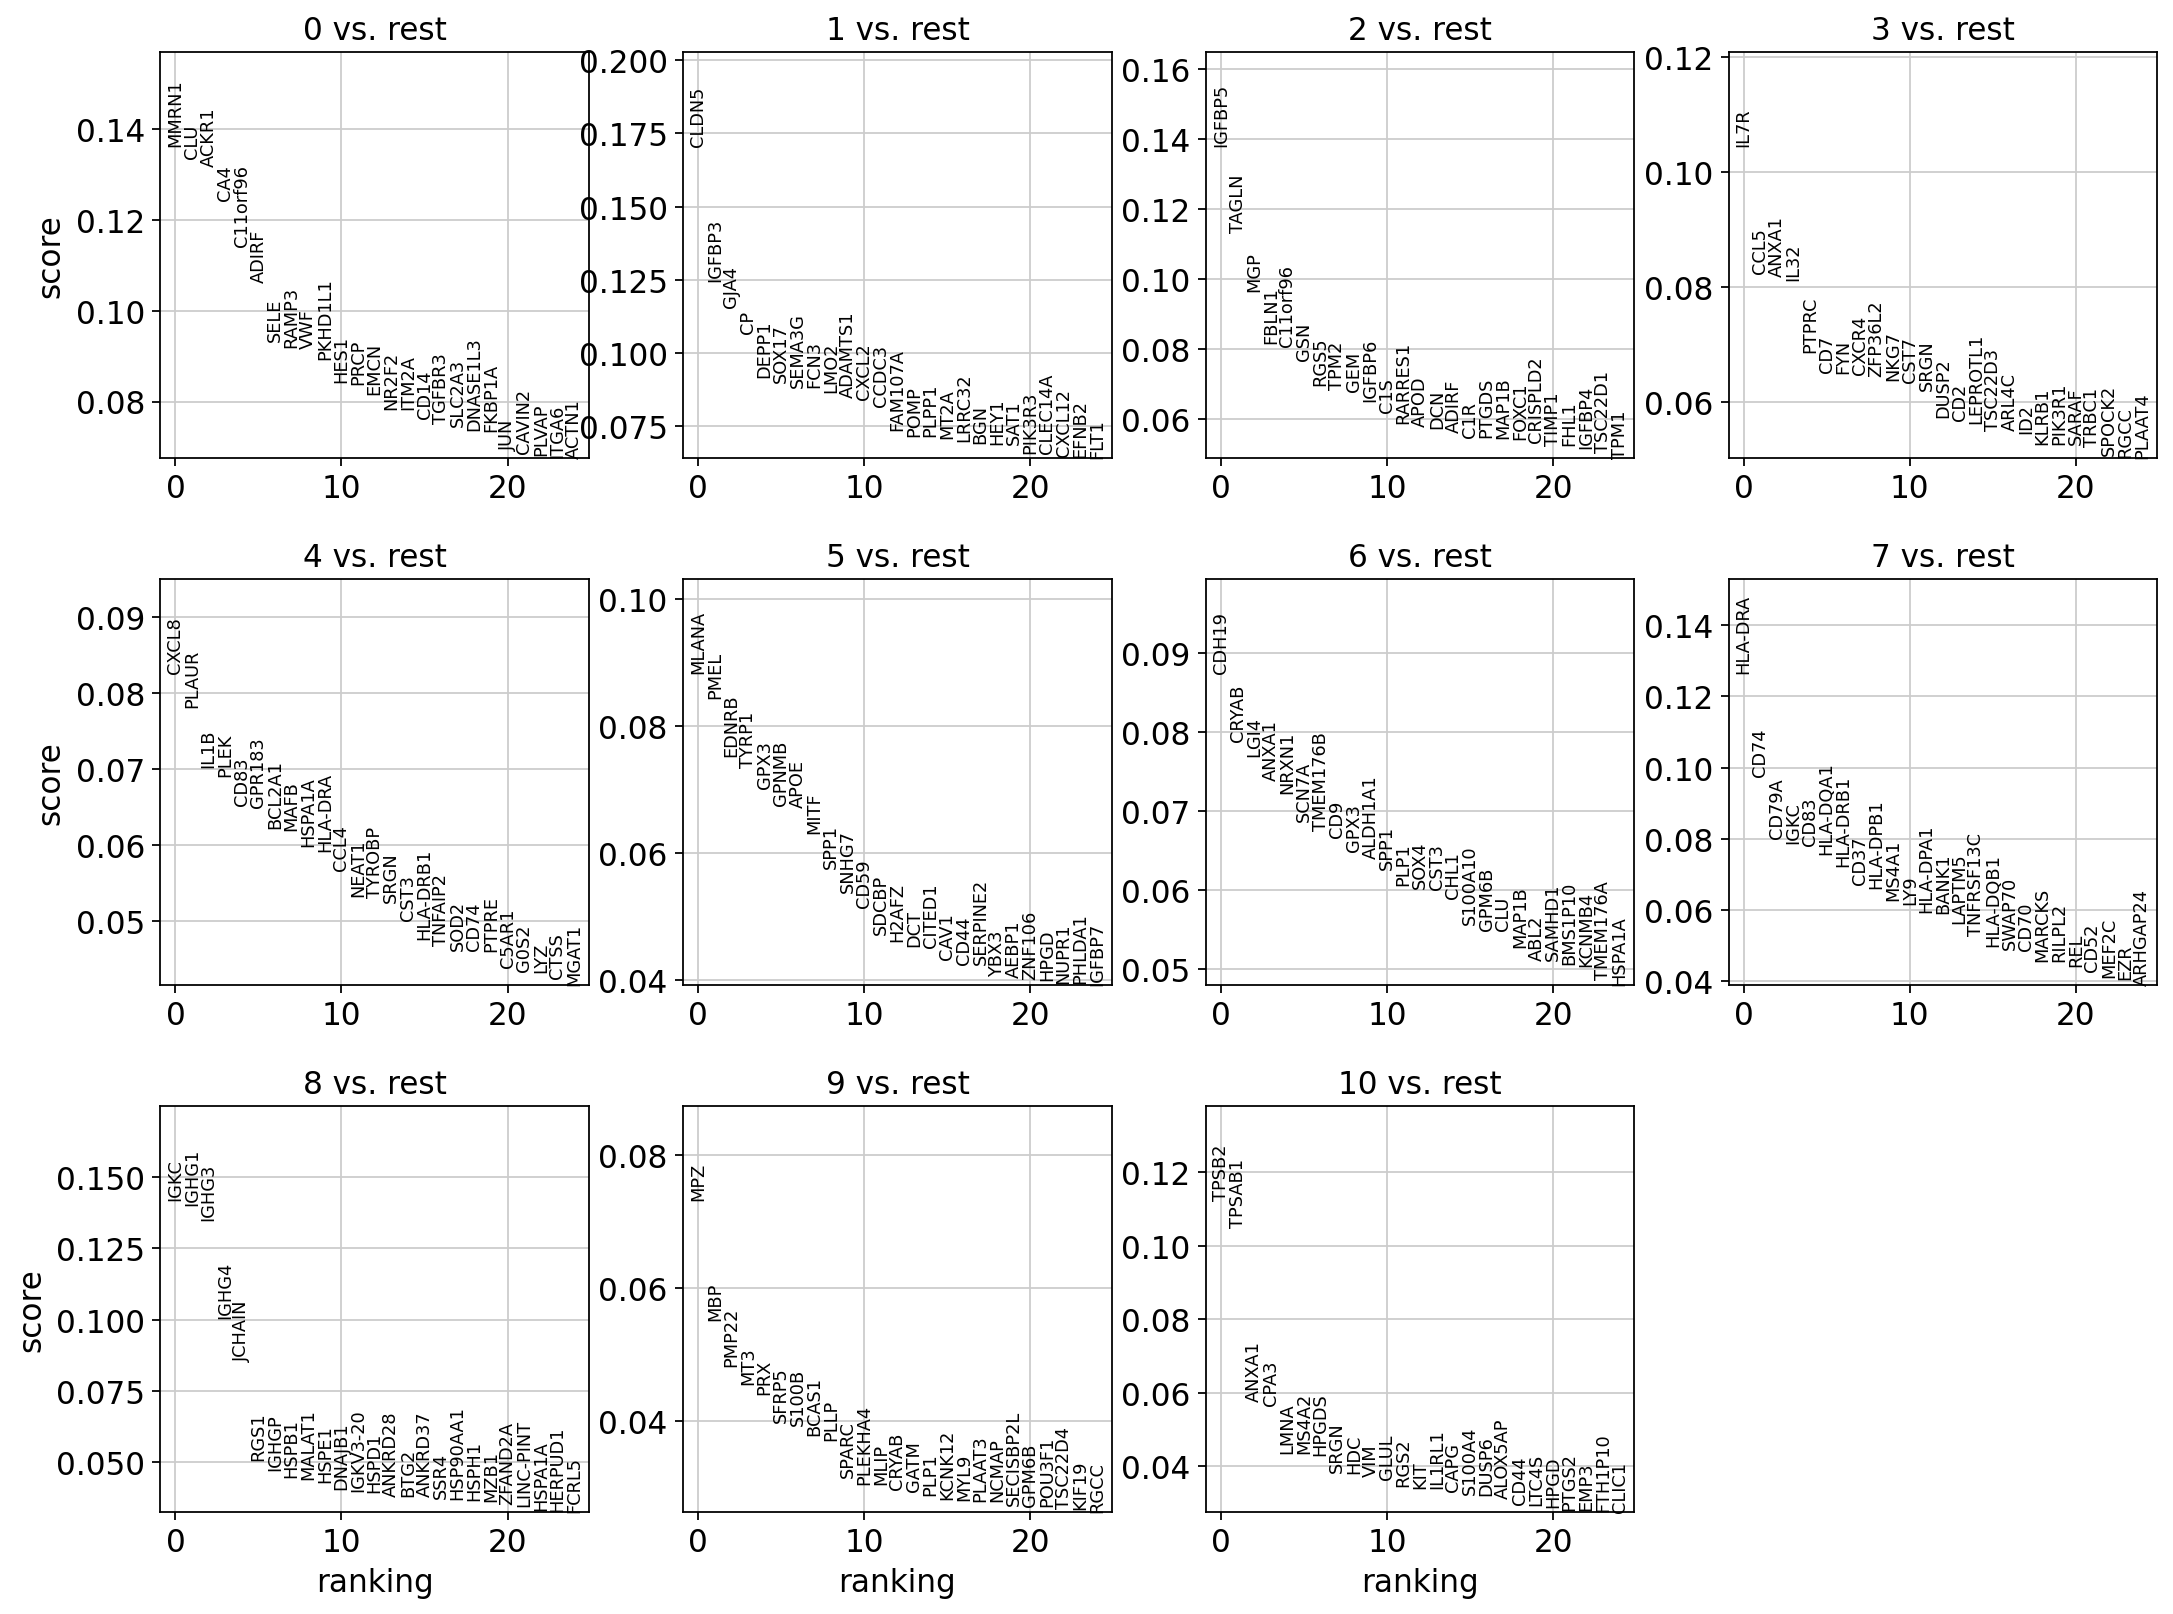

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [35]:
marker_genes = [
    'MMRN1', 
    'CLDN5', 
    'IGFBP5', 
    'PTPRC', 
    'TYROBP', 'FCER1G', 
    'MLANA', 
    'CDH19', 
    'CD37', 
    'IGHG4', 'IGHG1', 'IGHG3',
    'MPZ', 'MBP', 
    'CPA3', 'TPSAB1', 'TPSB2', 'MS4A2', 'KIT']

In [36]:
adata = sc.read(results_file)

In [37]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0        1         2      3       4       5      6      7      8  \
0    MMRN1    CLDN5    IGFBP5  SARAF  TYROBP   TOMM7  CDH19   CD37  IGHG4   
1      VWF   IGFBP3       C1S  PTPRC  FCER1G   MLANA   LGI4  RPS21  IGHG1   
2    RAMP3     LMO2     TAGLN  CXCR4   PLAUR  RPL37A  GPM6B  CD79A  IGHG3   
3  SLCO2A1   SEMA3G      FHL1  RPS29    AIF1   TYRP1    CD9  RPL39   IGKC   
4   PRSS23  CLEC14A  SERPING1  RPS27    PLEK   GPNMB  NRXN1  RPS27  FCRL5   

        9      10  
0     MPZ    CPA3  
1     MBP   TPSB2  
2   BCAS1  TPSAB1  
3  KCNK12   MS4A2  
4     PRX     KIT

In [38]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n  0_p      1_n  1_p       2_n  2_p    3_n  3_p     4_n  4_p  ...  \
0    MMRN1  0.0    CLDN5  0.0    IGFBP5  0.0  SARAF  0.0  TYROBP  0.0  ...   
1      VWF  0.0   IGFBP3  0.0       C1S  0.0  PTPRC  0.0  FCER1G  0.0  ...   
2    RAMP3  0.0     LMO2  0.0     TAGLN  0.0  CXCR4  0.0   PLAUR  0.0  ...   
3  SLCO2A1  0.0   SEMA3G  0.0      FHL1  0.0  RPS29  0.0    AIF1  0.0  ...   
4   PRSS23  0.0  CLEC14A  0.0  SERPING1  0.0  RPS27  0.0    PLEK  0.0  ...   

     6_n            6_p    7_n           7_p    8_n           8_p     9_n  \
0  CDH19  7.957587e-170   CD37  2.081021e-76  IGHG4  3.938085e-25     MPZ   
1   LGI4  9.944015e-165  RPS21  2.152534e-74  IGHG1  3.946713e-25     MBP   
2  GPM6B  3.430908e-156  CD79A  1.686158e-73  IGHG3  4.047300e-25   BCAS1   
3    CD9  1.714103e-151  RPL39  4.288009e-73   IGKC  1.924826e-23  KCNK12   
4  NRXN1  8.228247e-150  RPS27  7.064712e-72  FCRL5  2.284846e-22     PRX   

            9_p    10_n          10_p  
0  1.064952e-14    CPA3  2.203368e-13  
1  1.064952e-14   TPSB2  2.203368e-13  
2  1.064952e-14  TPSAB1  2.203368e-13  
3  1.079130e-14   MS4A2  2.218011e-13  
4  1.081510e-14     KIT  2.605323e-13  

[5 rows x 22 columns]

ranking genes
    finished (0:00:04)


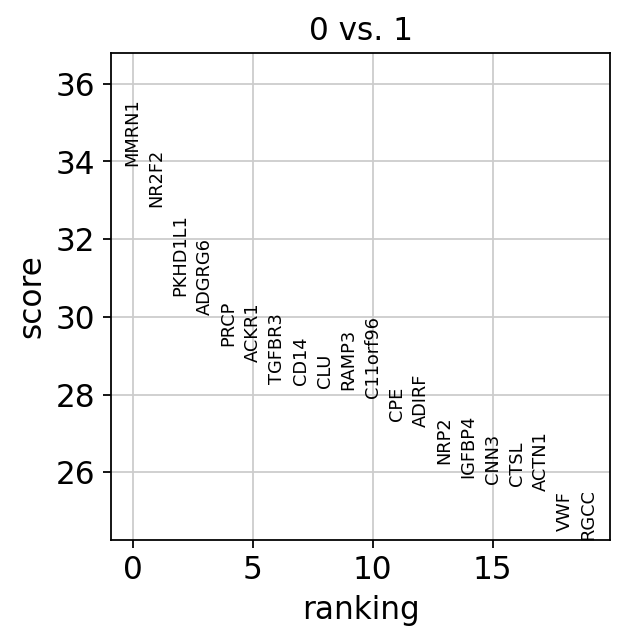

In [39]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

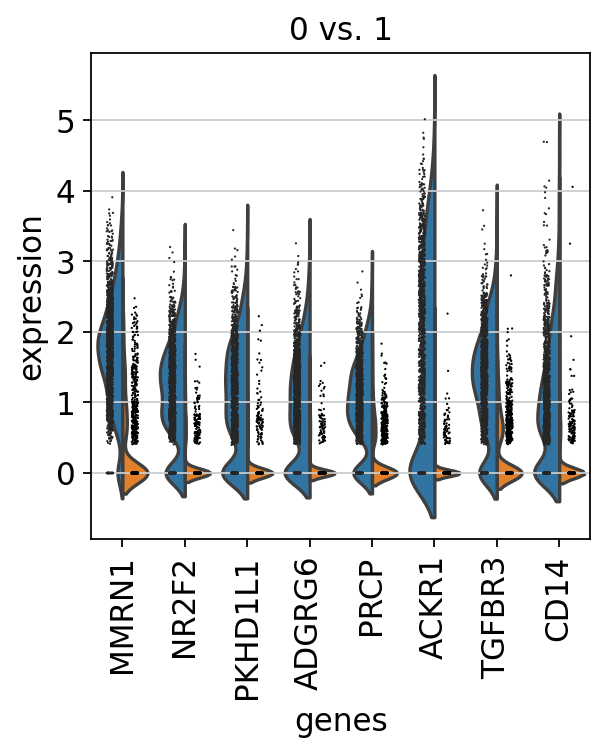

In [40]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [41]:
adata = sc.read(results_file)

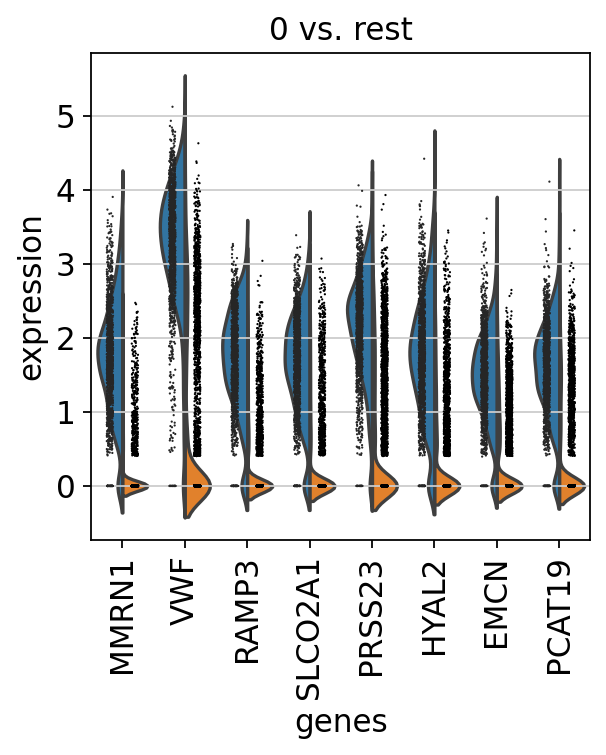

In [42]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

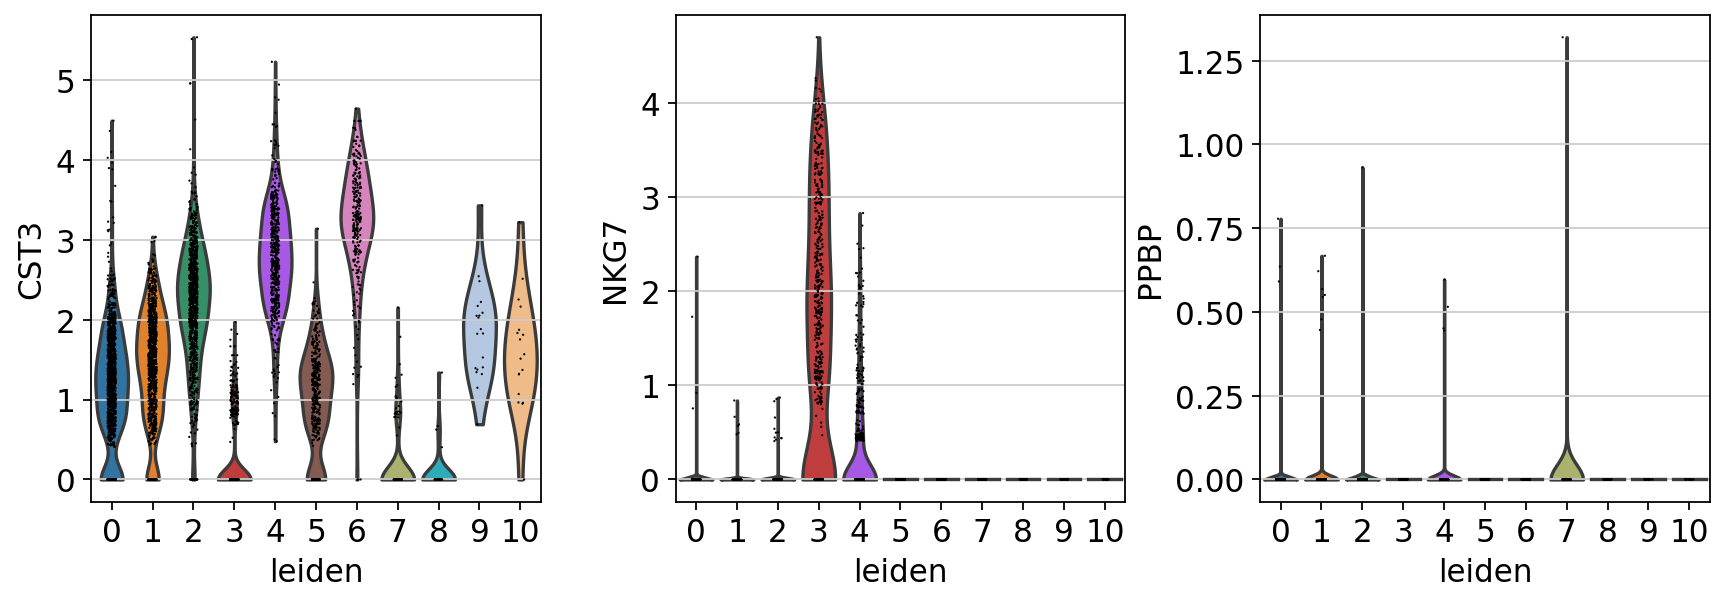

In [43]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [56]:
#based on the expression in protein atlas
new_cluster_names = [
    'Endothelial cells', 
    'Pericytes', 
    'Fibroblasts', 
    'T-cells',
    'Macrophages', 
    'Melanocytes',
    'non-myelinating SC',
    'B-cells',
    'RPE', 
    'myelinating SC',
    'Mast cells']
adata.rename_categories('leiden', new_cluster_names)

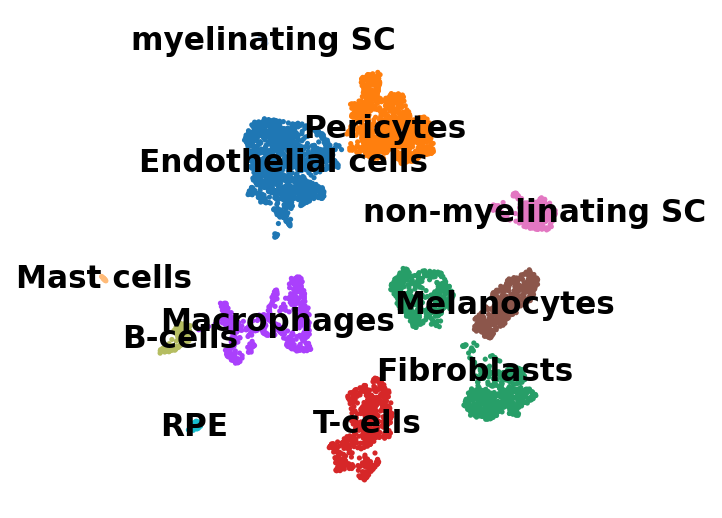

In [57]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

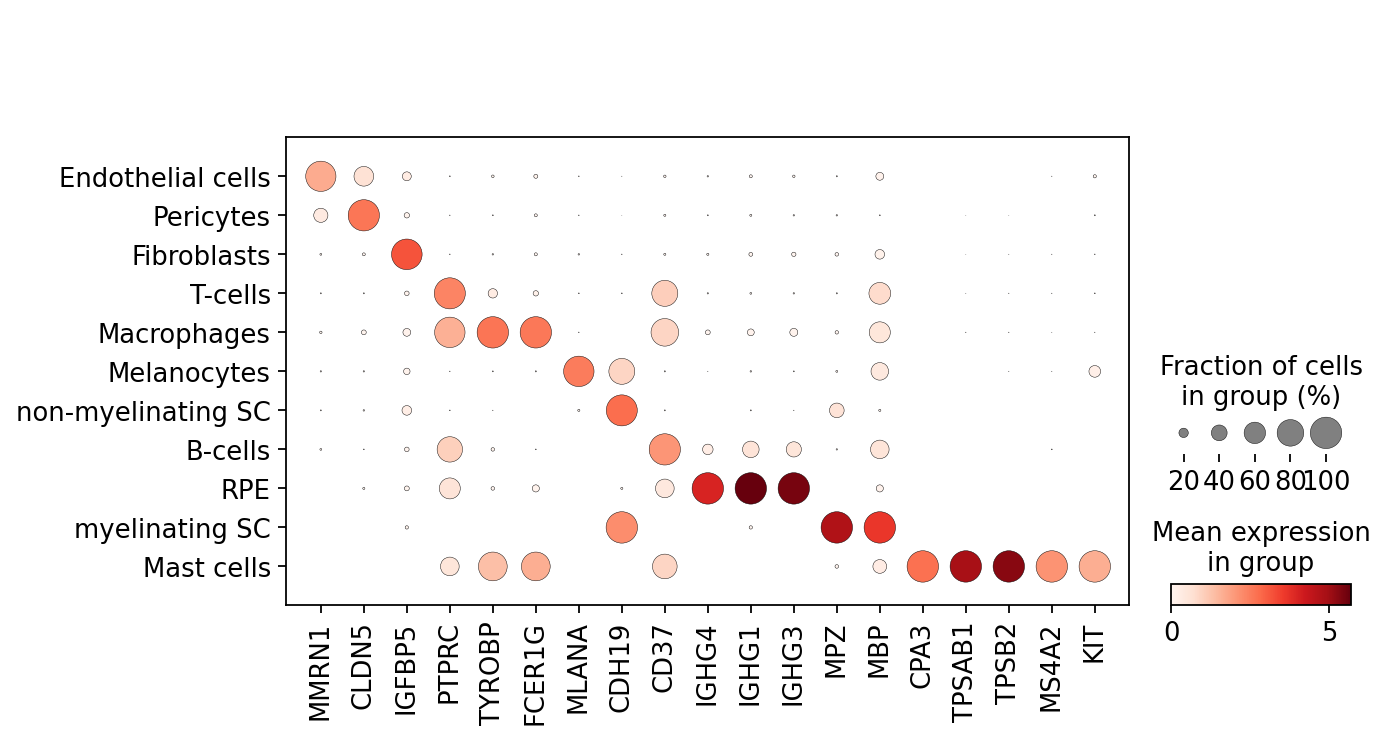

In [58]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

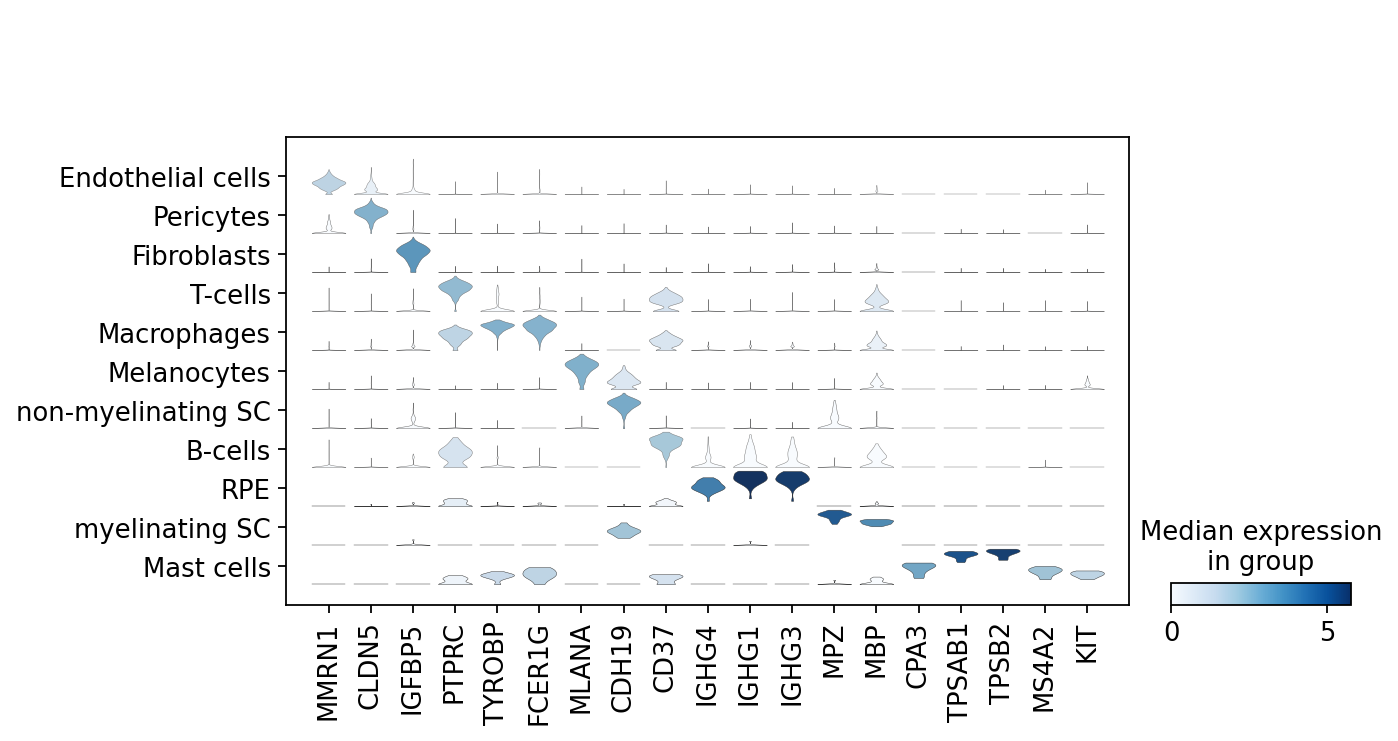

In [60]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90, save='.pdf');

In [48]:
adata

AnnData object with n_obs × n_vars = 5531 × 3823
    obs: 'GSM', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [49]:
adata.write(results_file, compression='gzip')

In [50]:
adata.raw.to_adata().write('./write/GSE138922_withoutX.h5ad')